# Positive and negative reviews classification

Task 5 - NLP - Positive and negative reviews classification
You’re given a dataset of product reviews by customers. The task is simply to classify reviews as positive or negative ones, achieving the best balanced accuracy you can. However, your solution should also be efficient and capable of running even on lower-tier machines. We don’t set any strict conditions besides the solution not requiring GPU and running reasonably fast on lower-end CPUs, but your creativity and skills in terms of squeezing the best performance from lightweight pipelines will be appreciated. While the main output of your work is the inference code for us to test it, we encourage you to also provide any additional code/notebooks (EDA, training, etc.). Their good quality will be an advantage.

The dataset is provided as 2 standard comma-separated CSV files. Each of them contains review IDs and either reviews themselves or their labels, respectively. Your solution will be evaluated on a private test dataset that is sampled from the same data distribution as the one provided to you. Feel free to train your model on the provided dataset from scratch or use third-party datasets for pretraining.

When delivering your solution, the inference code should be placed in a separate script called inference.py. It should be possible to install all the necessary packages to run it from requirements.txt using pip. All the additional files, like saved model parameters, should be placed near the inference script and loaded automatically. The inference script should accept an input file and write classification results into an output file in the same format as the provided dataset. A command to run your script should look as follows:
python3 inference.py test_reviews.csv test_labels_pred.csv

All the additional code can be provided either as plain Python scripts or Jupyter notebooks without any specific requirements for their interface. You’re encouraged to add a README on how to use them properly.

Deliverable: 
Working training and inference code, 
Any necessary supplementary files, 
A short report [in English] on the principle of operation of your solution (better with some illustrations)


## Import necessary libraries


In [1]:
import csv
import string
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report
from tensorflow.keras.metrics import Precision, Recall, AUC
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
import nltk
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.tokenize import word_tokenize
nltk.download('punkt')
nltk.download('stopwords')

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\пк\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\пк\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

## The main thing to pay attention to
<li>Tokenization, stemming and removing stopwords - reduce the size of vocab -> smaller time for training
<li>Simple model (LSTM or CNN) with 2-3 layers
<li>Using mini-batches for training
<li>Hyperparameter Tuning (small embedding_dim !)
<li>High risk of overfitting beacause of small data, so using Regularization (for example, dropout or L1, L2 regularization)

## Import .csv files with data

In [2]:
reviews_df = pd.read_csv('reviews.csv')
labels_df = pd.read_csv('labels.csv')

## Data Preprocessing

In [3]:
reviews_df.head()

,id,text
0,168,"Hi Leah, I ordered this early to give to a co-..."
1,26,"Good evening, \n I just received my order! I ..."
2,64,I couldn’t find where I could write a review b...
3,10,I received my order today and gave it to my si...
4,111,"﻿Max,\n\nWe received the heart but sadly are d..."


In [4]:
labels_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 254 entries, 0 to 253
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   id         254 non-null    int64 
 1   sentiment  254 non-null    object
dtypes: int64(1), object(1)
memory usage: 4.1+ KB


In [5]:
labels_df.head()

,id,sentiment
0,168,Positive
1,26,Positive
2,64,Positive
3,10,Positive
4,111,Negative


Therefore, there are no null values in the datasets, so there is no need for null values or any special preparation.

## Merge two tables on review id

In [6]:
combined_df = pd.merge(labels_df, reviews_df, on='id')

In [7]:
combined_df.head()

,id,sentiment,text
0,168,Positive,"Hi Leah, I ordered this early to give to a co-..."
1,26,Positive,"Good evening, \n I just received my order! I ..."
2,64,Positive,I couldn’t find where I could write a review b...
3,10,Positive,I received my order today and gave it to my si...
4,111,Negative,"﻿Max,\n\nWe received the heart but sadly are d..."


In [8]:
combined_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 254 entries, 0 to 253
Data columns (total 3 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   id         254 non-null    int64 
 1   sentiment  254 non-null    object
 2   text       254 non-null    object
dtypes: int64(1), object(2)
memory usage: 7.9+ KB


# Now replace the sentiment column from labels with a binary value. Suppose **positive - 1, negative - 0**


In [9]:
combined_df['label'] = combined_df['sentiment'].map({'Negative': 0, 'Positive': 1})

In [10]:
combined_df.head()

,id,sentiment,text,label
0,168,Positive,"Hi Leah, I ordered this early to give to a co-...",1
1,26,Positive,"Good evening, \n I just received my order! I ...",1
2,64,Positive,I couldn’t find where I could write a review b...,1
3,10,Positive,I received my order today and gave it to my si...,1
4,111,Negative,"﻿Max,\n\nWe received the heart but sadly are d...",0


In [11]:
combined_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 254 entries, 0 to 253
Data columns (total 4 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   id         254 non-null    int64 
 1   sentiment  254 non-null    object
 2   text       254 non-null    object
 3   label      254 non-null    int64 
dtypes: int64(2), object(2)
memory usage: 9.9+ KB


# Text Preprocessing
Convert input text to lowercase, tokenizes it, removes punctuation and common English stop words, applies stemming to the remaining tokens.

In [12]:
def preprocess_text(text):
    """
    Takes an input text, converts it to lowercase,
    tokenizes it,
    removes punctuation and common English stop words,
    applies stemming to the remaining tokens,
    and returns the preprocessed text as a string. 
    
    Args:
        text (string): text that must be pre-processed
    
    Returns:
        the preprocessed text as a string
    """
    
    
    text = text.lower()
    tokens = word_tokenize(text)
    
    # Stop_words in English like "i", "me", "we", "myself" and many others
    stop_words = set(stopwords.words('english'))
    
    # Remove punctuation
    tokens = [word for word in tokens if word not in string.punctuation]
    
    # Remove stop_words
    filtered_tokens = [word for word in tokens if word not in stop_words]
    
    # Remove morphological affixes from words, leaving only the word stem
    stemmer = PorterStemmer()
    stemmed_tokens = [stemmer.stem(word) for word in filtered_tokens]
    
    # Return stemmed words
    return " ".join(stemmed_tokens)

In [13]:
combined_df['preprocessed_text'] = combined_df['text'].apply(preprocess_text)

In [14]:
combined_df.info()
combined_df.head()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 254 entries, 0 to 253
Data columns (total 5 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   id                 254 non-null    int64 
 1   sentiment          254 non-null    object
 2   text               254 non-null    object
 3   label              254 non-null    int64 
 4   preprocessed_text  254 non-null    object
dtypes: int64(2), object(3)
memory usage: 11.9+ KB


,id,sentiment,text,label,preprocessed_text
0,168,Positive,"Hi Leah, I ordered this early to give to a co-...",1,hi leah order earli give co-work christma gift...
1,26,Positive,"Good evening, \n I just received my order! I ...",1,good even receiv order say- move tear detail c...
2,64,Positive,I couldn’t find where I could write a review b...,1,’ find could write review 5 star way order son...
3,10,Positive,I received my order today and gave it to my si...,1,receiv order today gave sister remind beauti d...
4,111,Negative,"﻿Max,\n\nWe received the heart but sadly are d...",0,﻿max receiv heart sadli disappoint two scratch...


## Split the data into train and test set

In [15]:
# Split the data into training and temporary data (dev + test)
X_train, X_dev_test, y_train, y_dev_test = train_test_split(combined_df['preprocessed_text'], combined_df['label'], test_size=0.3, random_state=47)

# Split the temporary data into dev and test sets
X_dev, X_test, y_dev, y_test = train_test_split(X_dev_test, y_dev_test, test_size=0.5, random_state=47)


# Trying model with Convolution layer

In [16]:
# Parameters for tokenizer 
vocab_size = 10000  # Size of the vocabulary
max_length = 120    # Length of input sequences
trunc_type='post'   # Specify the truncation type for sequences
oov_tok = "<OOV>"   # Special token to represent out-of-vocabulary 

In [17]:
tokenizer = Tokenizer(num_words = vocab_size, oov_token=oov_tok)

tokenizer.fit_on_texts(X_train)

# Generate train sequences
sequences = tokenizer.texts_to_sequences(X_train)
padded = pad_sequences(sequences,maxlen=max_length, truncating=trunc_type)

# Generate test sequences
testing_sequences = tokenizer.texts_to_sequences(X_test)
testing_padded = pad_sequences(testing_sequences,maxlen=max_length, truncating=trunc_type)

In [18]:
dropout_rate = 0.5  # Dropout rate
embedding_dim = 9   # Dimension of word embeddings
filters = 128       # Size of convolutional kernels
kernel_size = 5     # Number of filters in the convolutional layer
dense_dim = 16      

In [19]:
# Define the callback functions FOR ALL MODELS
model_checkpoint = ModelCheckpoint('best_model.h5', save_best_only=True, save_weights_only=True, monitor='val_loss', mode='min', verbose=1)
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True, verbose=1)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=3, min_lr=1e-3, verbose=1)

In [20]:
num_epochs = 100
batch_size = 64

# Trying model with Convolution layer

In [21]:
# Model Definition with Conv1D
model_conv = tf.keras.Sequential([
    tf.keras.layers.Embedding(vocab_size, embedding_dim, input_length=max_length),
    tf.keras.layers.Conv1D(filters, kernel_size, activation='relu'),
    tf.keras.layers.GlobalMaxPooling1D(),
    tf.keras.layers.Dropout(dropout_rate),
    tf.keras.layers.Dense(dense_dim, activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid')
])

# Compile the model
model_conv.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy', Precision(), Recall(), AUC(name='roc_auc')])

model_conv.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 120, 9)            90000     
                                                                 
 conv1d (Conv1D)             (None, 116, 128)          5888      
                                                                 
 global_max_pooling1d (Glob  (None, 128)               0         
 alMaxPooling1D)                                                 
                                                                 
 dropout (Dropout)           (None, 128)               0         
                                                                 
 dense (Dense)               (None, 16)                2064      
                                                                 
 dense_1 (Dense)             (None, 1)                 17        
                                                        

In [22]:
# Train the model with the callback functions
history_conv = model_conv.fit(padded, y_train, epochs=num_epochs, batch_size = batch_size, validation_data=(testing_padded, y_test),
                              callbacks=[model_checkpoint, early_stopping, reduce_lr])

Epoch 1/100
1/3 [=========>....................] - ETA: 2s - loss: 0.6963 - accuracy: 0.3750 - precision: 0.0000e+00 - recall: 0.0000e+00 - roc_auc: 0.6159
Epoch 1: val_loss improved from inf to 0.69136, saving model to best_model.h5
3/3 [==============================] - 2s 228ms/step - loss: 0.6936 - accuracy: 0.4294 - precision: 0.4783 - recall: 0.1100 - roc_auc: 0.5862 - val_loss: 0.6914 - val_accuracy: 0.6410 - val_precision: 0.7500 - val_recall: 0.6923 - val_roc_auc: 0.6686 - lr: 0.0010
Epoch 2/100
1/3 [=========>....................] - ETA: 0s - loss: 0.6905 - accuracy: 0.5938 - precision: 0.8148 - recall: 0.5116 - roc_auc: 0.6700
Epoch 2: val_loss improved from 0.69136 to 0.68529, saving model to best_model.h5
3/3 [==============================] - 0s 50ms/step - loss: 0.6902 - accuracy: 0.5876 - precision: 0.6216 - recall: 0.6900 - roc_auc: 0.5802 - val_loss: 0.6853 - val_accuracy: 0.6667 - val_precision: 0.6667 - val_recall: 1.0000 - val_roc_auc: 0.6361 - lr: 0.0010
Epoch 3/1

# Trying Bidirectional LSTM

In [ ]:
# Parameters
lstm_dim = 32
lstm2_dim = 16

In [23]:

# Model with LSTM
model_lstm = tf.keras.Sequential([
    tf.keras.layers.Embedding(vocab_size, embedding_dim, input_length=max_length),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(lstm_dim, return_sequences=True)),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(lstm2_dim)),
    tf.keras.layers.Dropout(dropout_rate),
    tf.keras.layers.Dense(dense_dim, activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid')
])

# Compile the model
model_lstm.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy', Precision(name='precision'), Recall(name='recall'), AUC(name='roc_auc')])

# Print the model summary
model_lstm.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (None, 120, 9)            90000     
                                                                 
 bidirectional (Bidirection  (None, 120, 64)           10752     
 al)                                                             
                                                                 
 bidirectional_1 (Bidirecti  (None, 32)                10368     
 onal)                                                           
                                                                 
 dropout_1 (Dropout)         (None, 32)                0         
                                                                 
 dense_2 (Dense)             (None, 16)                528       
                                                                 
 dense_3 (Dense)             (None, 1)                

In [24]:
# Train the model
history_lstm = model_lstm.fit(padded, y_train, epochs=num_epochs, batch_size = batch_size, validation_data=(testing_padded, y_test),
                              callbacks=[model_checkpoint, early_stopping, reduce_lr])

Epoch 1/100
3/3 [==============================] - ETA: 0s - loss: 0.6935 - accuracy: 0.4520 - precision: 0.5135 - recall: 0.5700 - roc_auc: 0.4473
Epoch 1: val_loss did not improve from 0.10298
3/3 [==============================] - 10s 920ms/step - loss: 0.6935 - accuracy: 0.4520 - precision: 0.5135 - recall: 0.5700 - roc_auc: 0.4473 - val_loss: 0.6896 - val_accuracy: 0.6667 - val_precision: 0.6667 - val_recall: 1.0000 - val_roc_auc: 0.5000 - lr: 0.0010
Epoch 2/100
3/3 [==============================] - ETA: 0s - loss: 0.6914 - accuracy: 0.5706 - precision: 0.5682 - recall: 1.0000 - roc_auc: 0.5049
Epoch 2: val_loss did not improve from 0.10298
3/3 [==============================] - 0s 122ms/step - loss: 0.6914 - accuracy: 0.5706 - precision: 0.5682 - recall: 1.0000 - roc_auc: 0.5049 - val_loss: 0.6836 - val_accuracy: 0.6667 - val_precision: 0.6667 - val_recall: 1.0000 - val_roc_auc: 0.5385 - lr: 0.0010
Epoch 3/100
3/3 [==============================] - ETA: 0s - loss: 0.6881 - accur

# Trying LSTM with Convolution

In [26]:
model = tf.keras.Sequential([
    tf.keras.layers.Embedding(vocab_size, embedding_dim, input_length=max_length),
    tf.keras.layers.Conv1D(filters, kernel_size, activation='relu'),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(lstm_dim)),
    tf.keras.layers.Dropout(dropout_rate),
    tf.keras.layers.Dense(dense_dim, activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid')
])
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy', Precision(name='precision'), Recall(name='recall'), AUC(name='roc_auc')])

model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_3 (Embedding)     (None, 120, 9)            90000     
                                                                 
 conv1d_2 (Conv1D)           (None, 116, 128)          5888      
                                                                 
 bidirectional_2 (Bidirecti  (None, 64)                41216     
 onal)                                                           
                                                                 
 dropout_2 (Dropout)         (None, 64)                0         
                                                                 
 dense_4 (Dense)             (None, 16)                1040      
                                                                 
 dense_5 (Dense)             (None, 1)                 17        
                                                      

In [27]:
# Train the model
history = model.fit(padded, y_train, epochs=num_epochs, batch_size = batch_size, validation_data=(testing_padded, y_test),
                              callbacks=[model_checkpoint, early_stopping, reduce_lr])

Epoch 1/100
3/3 [==============================] - ETA: 0s - loss: 0.6936 - accuracy: 0.4689 - precision: 0.5341 - recall: 0.4700 - roc_auc: 0.4766
Epoch 1: val_loss did not improve from 0.10298
3/3 [==============================] - 7s 553ms/step - loss: 0.6936 - accuracy: 0.4689 - precision: 0.5341 - recall: 0.4700 - roc_auc: 0.4766 - val_loss: 0.6870 - val_accuracy: 0.6667 - val_precision: 0.6667 - val_recall: 1.0000 - val_roc_auc: 0.5385 - lr: 0.0010
Epoch 2/100
3/3 [==============================] - ETA: 0s - loss: 0.6909 - accuracy: 0.5650 - precision: 0.5650 - recall: 1.0000 - roc_auc: 0.4523
Epoch 2: val_loss did not improve from 0.10298
3/3 [==============================] - 0s 97ms/step - loss: 0.6909 - accuracy: 0.5650 - precision: 0.5650 - recall: 1.0000 - roc_auc: 0.4523 - val_loss: 0.6819 - val_accuracy: 0.6667 - val_precision: 0.6667 - val_recall: 1.0000 - val_roc_auc: 0.5769 - lr: 0.0010
Epoch 3/100
3/3 [==============================] - ETA: 0s - loss: 0.6894 - accurac

In [28]:
def plot_metrics(history, metrics):
    """
    Plot specified metrics from the training history.
    
    Parameters:
    - history: Training history object from model.fit
    - metrics: List of metric names to plot
    
    Example usage:
    plot_metrics(history_lstm, ["accuracy", "loss", "recall", "precision", "roc_auc"])
    """
    
    # Define the number of subplots based on the number of metrics
    num_metrics = len(metrics)
    fig, axes = plt.subplots(1, num_metrics, figsize=(15, 4))

    # Iterate through the metrics and plot them
    for i, metric in enumerate(metrics):
        ax = axes[i]
        ax.plot(history.history[metric], label=metric)
        ax.plot(history.history['val_'+metric], label='val_'+metric)
        ax.set_xlabel("Epochs")
        ax.set_ylabel(metric)
        ax.legend()

    plt.tight_layout()
    plt.show()


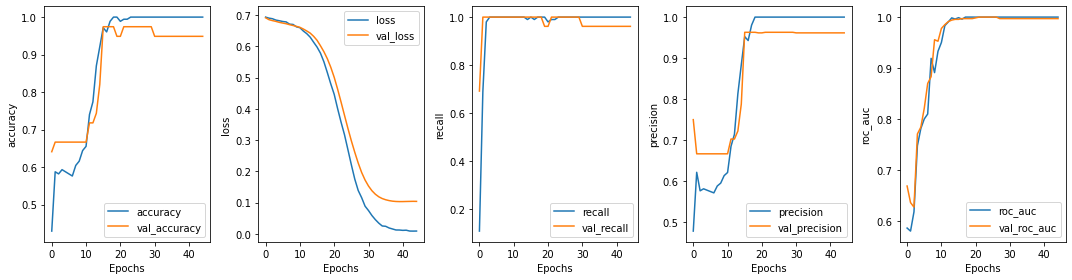

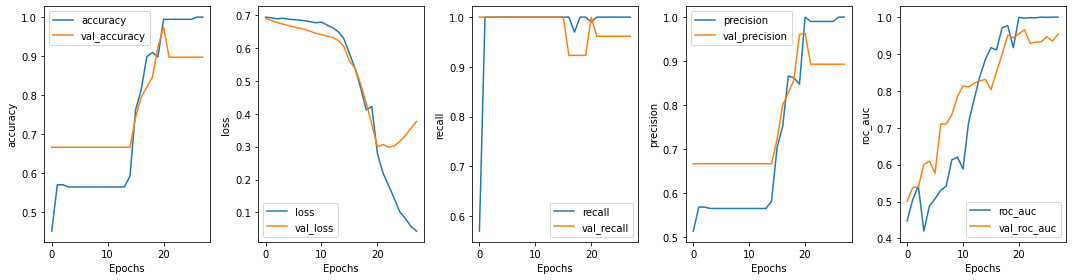

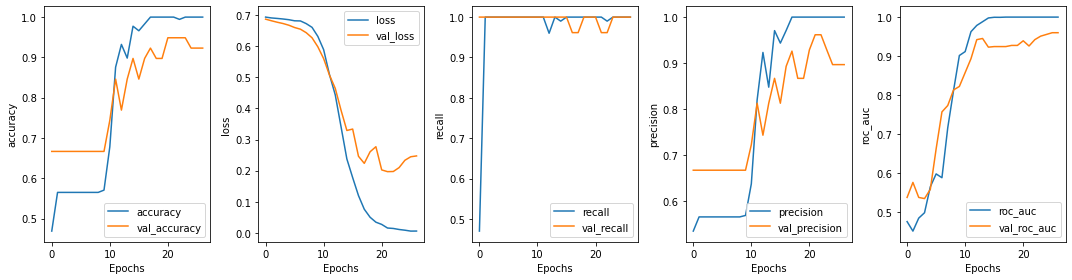

In [29]:
# Display metric for different model
plot_metrics(history_conv, ["accuracy", "loss", "recall", "precision", "roc_auc"])
plot_metrics(history_lstm, ["accuracy", "loss", "recall", "precision", "roc_auc"])
plot_metrics(history, ["accuracy", "loss", "recall", "precision", "roc_auc"])

# Attention: model with LSTM. The val_loss increased - maybe overfitting

In [30]:
# Generate and pad the training sequences
sequences = tokenizer.texts_to_sequences(X_dev)
padded = pad_sequences(sequences,maxlen=max_length, truncating=trunc_type)
y_pred = model_conv.predict(padded)

# Save the model of model with conv
model_conv.save('model_conv.h5')

# Convert predicted probabilities to binary labels
y_pred_binary = (y_pred > 0.5).astype(int)

accuracy = accuracy_score(y_dev, y_pred_binary)
print(f"Accuracy: {accuracy:.2f}")

# Generate a classification report
class_report = classification_report(y_dev, y_pred_binary)
print("Classification Report:\n", class_report)



2/2 [==============================] - 0s 3ms/step
Accuracy: 0.97
Classification Report:
               precision    recall  f1-score   support

           0       0.92      1.00      0.96        12
           1       1.00      0.96      0.98        26

    accuracy                           0.97        38
   macro avg       0.96      0.98      0.97        38
weighted avg       0.98      0.97      0.97        38



D:\anaconda\lib\site-packages\keras\src\engine\training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(
